## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = data_path + 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = data_path + 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = data_path + 'uniprotdomains.gz'
gene_domain_file_path = data_path + 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
scz_variants_file_path = data_path + 'scz.tsv.gz'
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'
ukb_variants_file_path = data_path + 'ukb24310_c19.qced_nonrel.vmiss.gz'

## Define helper methods

In [3]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')
    
    print(cases_df)

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])
    print(unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand'))
    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Load data

In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [5]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [12]:
# Read the data into a DataFrame
scz_df = pd.read_csv(scz_variants_file_path, sep='\t')

# Split the locus column
scz_df[['chr', 'pos']] = scz_df['locus'].str.split(':', expand=True)

# Convert 'chr' column
scz_df['chr'] = 'chr' + scz_df['chr'].astype(str)

# Ensure that the 'pos' column is converted to integers
scz_df['pos'] = pd.to_numeric(scz_df['pos'], errors='coerce').fillna(0).astype(int)

filter_consequence_list = [
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "coding_sequence_variant",
    "downstream_gene_variant",
    "intergenic_variant",
    "intron_variant",
    "mature_miRNA_variant",
     "non_coding_transcript_exon_variant",
    "non_coding_transcript_variant",
    "null",
    "synonymous_variant",
   "upstream_gene_variant",
    "splice_region_variant",
    "stop_retained_variant",
    "protein_altering_variant"
]

pLoF_consequence_list = [
    'stop_gained',
    'splice_acceptor_variant',
    'splice_donor_variant',
    'frameshift_variant'
]

# Filter rows
scz_df = scz_df[~scz_df['consequence'].isin(filter_consequence_list)]
scz_df = scz_df[~scz_df['consequence'].isna()]

# Apply the liftover function to each row in the DataFrame
scz_df[['chr', 'pos']] = scz_df.apply(liftover, axis=1, result_type='expand')

scz_df = scz_df[(scz_df['chr'] != "chrX") & (scz_df['chr'] != "chrY") & (scz_df['chr'] != "chrMT")]

# Add gene names
scz_df = pd.merge(scz_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

scz_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,cadd,mpc,polyphen,group,...,est,se,qp,i2,in_analysis,source,k,chr,pos,gene_name
0,1:139290,"[""TG"",""T""]",ENSG00000237683,frameshift_variant,c.19delC,p.Gln7LysfsTer98,NaN,NaN,NaN,AFR (genomes),...,NaN,NaN,NaN,NaN,True,genomes,NaN,chr1,139290,NaN
1,1:139290,"[""TG"",""T""]",ENSG00000237683,frameshift_variant,c.19delC,p.Gln7LysfsTer98,NaN,NaN,NaN,meta,...,NaN,NaN,NaN,NaN,True,genomes,NaN,chr1,139290,NaN
6,1:819959,"[""C"",""T""]",ENSG00000269308,splice_acceptor_variant,c.35-2C>T,NaN,0.001,NaN,NaN,Estonian_genome_EST,...,0.091681,0.688460,NaN,NaN,NaN,NaN,NaN,chr1,884579,NaN
7,1:819959,"[""C"",""T""]",ENSG00000269308,splice_acceptor_variant,c.35-2C>T,NaN,0.001,NaN,NaN,GPC_genomes_AFR,...,0.078467,0.082274,NaN,NaN,NaN,NaN,NaN,chr1,884579,NaN
8,1:819959,"[""C"",""T""]",ENSG00000269308,splice_acceptor_variant,c.35-2C>T,NaN,0.001,NaN,NaN,GPC_genomes_AMR,...,-0.057189,0.896890,NaN,NaN,NaN,NaN,NaN,chr1,884579,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195915,22:51214273,"[""CA"",""C""]",ENSG00000079974,frameshift_variant,c.223delT,p.Trp75GlyfsTer38,NaN,NaN,NaN,meta,...,NaN,NaN,NaN,NaN,True,"gnomAD exomes, gnomAD genomes",NaN,chr22,50775845,RABL2B
9195916,22:51215097,"[""C"",""A""]",ENSG00000079974,splice_donor_variant,c.217+1G>T,NaN,23.000,NaN,NaN,EUR (exomes),...,NaN,NaN,NaN,NaN,True,exomes,NaN,chr22,50776669,RABL2B
9195917,22:51215097,"[""C"",""A""]",ENSG00000079974,splice_donor_variant,c.217+1G>T,NaN,23.000,NaN,NaN,meta,...,NaN,NaN,NaN,NaN,True,exomes,NaN,chr22,50776669,RABL2B
9195918,22:51215153,"[""G"",""T""]",ENSG00000079974,stop_gained,c.162C>A,p.Tyr54Ter,36.000,NaN,NaN,EUR (exomes),...,NaN,NaN,NaN,NaN,True,exomes,NaN,chr22,50776725,RABL2B


In [6]:
# Define path to predictions file
rgc_predictions_file_path = results_path + 'HMM_rgc_0.9_over20_chr2_predictions_rgc_wgs.tsv.gz'

# Load in saved predictions for rgc dataset
predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Schizophrenia pLoF Analysis using Fisher's Exact Test

In [14]:
# Parameters for analysis
prob_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = scz_df

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]
    
    # Subset analysis to pLoFs
    cases_df = chr_variant_results_df[chr_variant_results_df['consequence'].isin(pLoF_consequence_list)]
    
    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(results_path + 'scz_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
              locus         alleles          gene_id           consequence  \
0          1:139290      ["TG","T"]  ENSG00000237683    frameshift_variant   
1          1:139290      ["TG","T"]  ENSG00000237683    frameshift_variant   
11         1:861288  ["G","GGCTCT"]  ENSG00000268179    frameshift_variant   
12         1:861288  ["G","GGCTCT"]  ENSG00000268179    frameshift_variant   
73         1:866424       ["A","G"]  ENSG00000268179  splice_donor_variant   
...             ...             ...              ...                   ...   
984985  1:249212280       ["G","A"]  ENSG00000185220           stop_gained   
985000  1:249212316  ["GGACCT","G"]  ENSG00000185220    frameshift_variant   
985063  1:249212487      ["AC","A"]  ENSG00000185220    frameshift_variant   
985066  1:249212495      ["AC","A"]  ENSG00000185220    frameshift_variant   
985067  1:2492124

                0         1
985086   4.299594  0.085244
985088   2.006929  0.149815
985107        inf  0.306131
985149        inf  0.394118
985182   0.000000  1.000000
...           ...       ...
1643270  4.299594  0.085244
1643272  1.433477  0.563149
1643355  0.000000  1.000000
1643717  0.521051  1.000000
1643722  0.000000  1.000000

[6607 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 3
               locus        alleles          gene_id              consequence  \
1643793     3:361465     ["G","GC"]  ENSG00000134121       frameshift_variant   
1643794     3:361465     ["G","GC"]  ENSG00000134121       frameshift_variant   
1643908     3:367748     ["G","GT"]  ENSG00000134121     splice_donor_variant   
1643909     3:367748     ["G","GT"]  ENSG00000

                0         1
2217819  0.195357  0.119075
2217820  0.293635  0.035300
2217828  1.537383  0.649359
2217941  0.000000  0.231873
2218157  0.000000  1.000000
...           ...       ...
2599765  0.000000  0.136419
2599766  0.000000  0.556306
2599771  0.000000  1.000000
2599806  0.000000  1.000000
2599807  0.000000  1.000000

[3963 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 5
               locus        alleles          gene_id         consequence  \
2599943     5:140709  ["C","CTGCA"]  ENSG00000153404  frameshift_variant   
2599974     5:140787    ["CAA","C"]  ENSG00000153404  frameshift_variant   
2599976     5:140787    ["CAA","C"]  ENSG00000153404  frameshift_variant   
2599977     5:140791    ["CTG","C"]  ENSG00000153404  frameshift_v

                0         1
3040378  2.006867  0.395401
3040475  2.149490  0.534223
3040513       inf  1.000000
3040559  0.000000  1.000000
3040576  0.000000  1.000000
...           ...       ...
3547387       inf  0.306142
3547415  0.859754  1.000000
3547540       inf  0.394118
3547579       inf  1.000000
3547587  0.000000  1.000000

[5473 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 7
               locus              alleles          gene_id  \
3547681     7:193627  ["CCGGCCCGCGT","C"]  ENSG00000177706   
3547682     7:193627  ["CCGGCCCGCGT","C"]  ENSG00000177706   
3547759     7:195711           ["TC","T"]  ENSG00000177706   
3547771     7:195733            ["G","A"]  ENSG00000177706   
3547772     7:195733            ["G","A"]  ENSG00000177706  

                0         1
3971704  1.289802  0.518992
3971705  0.720351  0.579045
3971751  0.000000  0.164218
3971777  2.267027  0.518570
3972154       inf  1.000000
...           ...       ...
4283011  1.070302  0.781205
4283016       inf  1.000000
4283213       inf  0.418251
4283215  0.000000  1.000000
4283237  0.000000  1.000000

[3407 rows x 2 columns]
                 gene_id gene_name           group  total_ac_case  \
4015172  ENSG00000130227      XPO7            meta             13   
4097306  ENSG00000023287    RB1CC1            meta             11   
4047046  ENSG00000134014      ELP3  EUR-N (exomes)             13   

         total_an_case  total_ac_ctrl  total_an_ctrl  odds_ratio       p_value  
4015172          48496              1         194644   52.190644  9.009053e-09  
4097306          48496              4         194644   11.039703  1.211484e-05  
4047046          14554              1          22374   20.001994  4.899034e-05  
--------------------------------------

                0         1
4661022  2.562719  0.277306
4661023  2.293918  0.012403
4661028  3.009988  0.062080
4661071  0.000000  1.000000
4661080       inf  1.000000
...           ...       ...
5032010  0.000000  0.283613
5032084       inf  0.306131
5032170  0.401349  0.704517
5032240       inf  0.317518
5032288  0.000000  0.283613

[3924 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 11
                locus                                            alleles  \
5032341     11:193734                                         ["CG","C"]   
5032383     11:193815                                          ["C","G"]   
5032385     11:193815                                          ["C","G"]   
5032387     11:193815                                         ["C

                0         1
5632713  2.149555  0.596248
5632714  2.006908  0.198370
5633040  0.000000  1.000000
5633041       inf  0.155323
5633251       inf  0.142377
...           ...       ...
6131890  2.161342  0.097336
6131905  0.716459  1.000000
6131907  0.768639  1.000000
6132186       inf  1.000000
6132187       inf  0.199457

[5527 rows x 2 columns]
                 gene_id gene_name group  total_ac_case  total_an_case  \
5757273  ENSG00000174718     RESF1  meta             37          48496   

         total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
5757273             63         194644    2.358235  0.000078  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 13
                locus                                            alleles  \
6132239   13:19748089          ["C","CTTTGGGAGGCCAAGGTGGATTTCTTGAACTGA"]   
6132241   13:19748089  ["C","CTTTGGGAGGCCAAGGTGGATTTCTTGAACTGAGTTTGAG...   
6132256   13

                0         1
6301742       inf  0.250907
6301752  0.668928  1.000000
6301753  0.000000  0.522409
6301836  0.000000  1.000000
6301888  2.408253  0.201885
...           ...       ...
6602981       inf  0.317518
6603014  0.000000  1.000000
6603016  3.074904  0.565950
6603202  5.844872  0.085309
6603203  2.675809  0.261608

[3244 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 15
                locus     alleles          gene_id         consequence  \
6603220   15:22368596  ["CA","C"]  ENSG00000182974  frameshift_variant   
6603223   15:22368612  ["G","GT"]  ENSG00000182974  frameshift_variant   
6603224   15:22368612  ["G","GT"]  ENSG00000182974  frameshift_variant   
6603225   15:22368630   ["C","T"]  ENSG00000182974         stop_gained   

                0         1
6937487  0.000000  0.590398
6937635  0.501691  1.000000
6937672  1.074717  1.000000
6937719  0.000000  1.000000
6937792  0.823275  0.717511
...           ...       ...
7338431  0.926204  1.000000
7338453  3.224890  0.083397
7338512  0.521051  1.000000
7338647  0.000000  0.320093
7338740       inf  1.000000

[4326 rows x 2 columns]
                 gene_id gene_name         group  total_ac_case  \
7137840  ENSG00000099381    SETD1A          meta             18   
6987058  ENSG00000167978     SRRM2          meta             16   
6987098  ENSG00000167978     SRRM2  EUR (exomes)             10   
7029330  ENSG00000183454    GRIN2A          meta              9   

         total_an_case  total_ac_ctrl  total_an_ctrl  odds_ratio       p_value  
7137840          48496              3         194644   24.090226  1.767910e-10  
6987058          48496              9         194644    7.137330  1.984290e-06  
6987098          17748              0          38148        

                0         1
7890460  1.317103  0.277422
7890467  1.612380  0.347446
7890469  0.768591  0.774242
7890478  0.000000  1.000000
7890483  0.000000  1.000000
...           ...       ...
8040504  1.416620  0.437449
8040526       inf  0.418251
8040565  1.537383  0.649359
8041867       inf  0.317518
8041868  1.337877  0.589290

[1472 rows x 2 columns]
                 gene_id gene_name group  total_ac_case  total_an_case  \
7912100  ENSG00000101745   ANKRD12  meta             25          48496   

         total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
7912100             31         194644    3.237935  0.000029  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19
               locus         alleles          gene_id         consequence  \
8041997    19:282141  ["G","GCAGCC"]  ENSG00000141934  frameshift_variant   
8042006    19:282175     ["G","GGA"]  ENSG00000141934  frameshift_variant   
8042007  

                0         1
8669956  2.149749  0.305798
8669957  2.867056  0.071831
8670043       inf  0.394118
8670083       inf  1.000000
8670156  0.000000  0.342606
...           ...       ...
8898542       inf  0.306131
8898779  1.234976  0.760418
8898804  3.074904  0.565950
8898857  0.000000  1.000000
8898892       inf  0.100814

[2672 rows x 2 columns]
                 gene_id gene_name group  total_ac_case  total_an_case  \
8851510  ENSG00000054793     ATP9A  meta             15          48496   

         total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
8851510             11         194644    5.474488  0.000025  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 21
               locus        alleles          gene_id           consequence  \
8899050  21:10906994     ["C","CT"]  ENSG00000166157    frameshift_variant   
8899051  21:10906994     ["C","CT"]  ENSG00000166157    frameshift_variant   
889906

                0         1
9004286  0.000000  0.342606
9004287  0.000000  0.606515
9004302  0.000000  1.000000
9004303  1.605469  0.632498
9004312  0.000000  1.000000
...           ...       ...
9195893  0.334454  0.486103
9195894       inf  1.000000
9195904  0.000000  0.314487
9195907  0.000000  1.000000
9195912  6.150653  0.082586

[2243 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []


,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
0,ENSG00000116539,ASH1L,meta,9,48496,2,194644,18.064409,0.000018
1,ENSG00000162441,LZIC,meta,12,48496,9,194644,5.352556,0.000189
2,ENSG00000159164,SV2A,meta,10,48496,7,194644,5.734704,0.000482
3,ENSG00000127603,MACF1,meta,16,48496,19,194644,3.380667,0.000508
4,ENSG00000116698,SMG7,meta,7,48496,3,194644,9.366296,0.000849
...,...,...,...,...,...,...,...,...,...
98285,ENSG00000183473,NaN,meta,3,48496,12,194644,1.003403,1.000000
98286,ENSG00000133466,C1QTNF6,FIN (exomes),0,1888,1,15968,0.000000,1.000000
98287,ENSG00000133466,C1QTNF6,AMR (exomes),0,2776,1,6292,0.000000,1.000000
98288,ENSG00000133466,C1QTNF6,ASJ (exomes),0,1738,2,4830,0.000000,1.000000


In [38]:
# # Parameters for analysis
# prob_thr = 0.6
# cnt_thr = 5
# significance_thr = 1
# variant_results_df = scz_df
# # predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

# filtered_predictions_df = predictions_df[(predictions_df['prob_0'] >= prob_thr)]

# variant_results_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
#                                         (variant_results_df['an_case'] > 0) & 
#                                         (variant_results_df['an_ctrl'] > 0)]

# # Filter variant results for positions over probability threshold
# cases_df = pd.merge(filtered_predictions_df, variant_results_df, on=['chr', 'pos'])

# # Subset analysis to pLoFs
# cases_df = cases_df[cases_df['consequence'].isin(pLoF_consequence_list)]

# # Apply fishers exact test to get signicance scores from cases data
# tested_df = apply_fishers_exact_test(cases_df)

# # Filter rows where p_value < significance threshold and append these rows to the DataFrame
# significant_genes_df = tested_df[tested_df['p_value'] <= significance_thr]

# # Display the sorted DataFrame
# # print(tested_df[tested_df['p_value'] < .0001])
    
# # Write significant_genes_df to a csv to avoid recomputing
# # significant_genes_df.to_csv(results_path + 'scz_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

# significant_genes_df #[significant_genes_df['p_value'] < .0001]

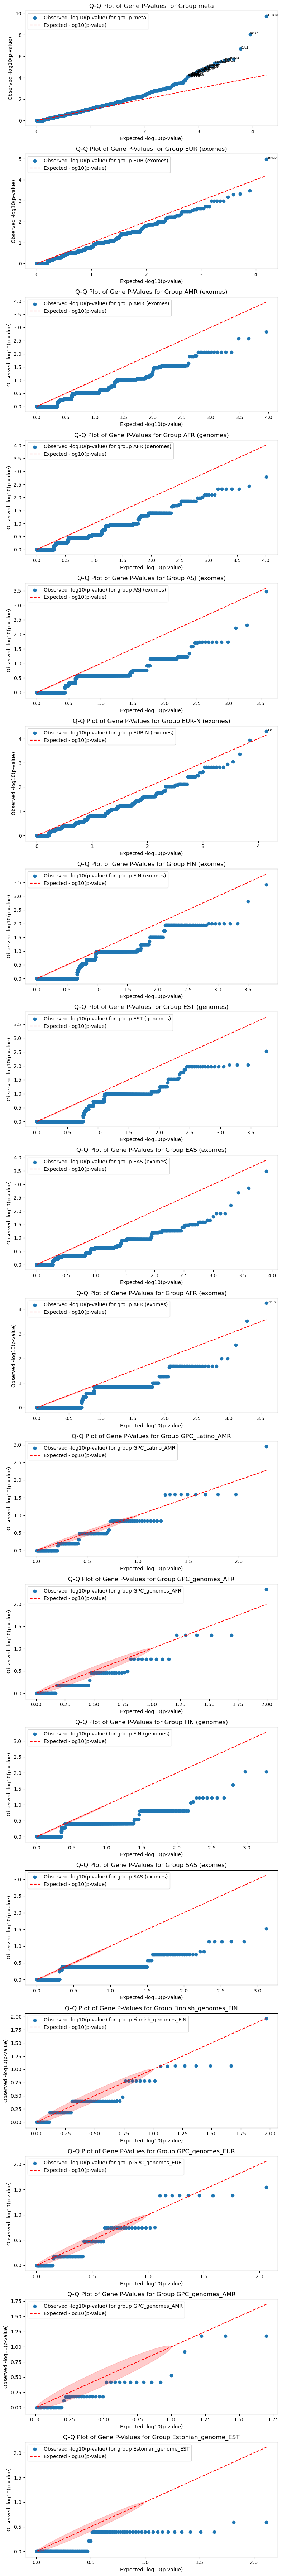

In [15]:
plot_group_QQ(significant_genes_df)

## Combine RGC constraint and Alpha Missense pathogenicity into meta regression model

In [19]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
variants_filtered_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) &
                                          (variant_results_df['an_case'] > 0) &
                                          (variant_results_df['an_ctrl'] > 0)
                                         ].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", 'cadd', "mpc", "polyphen", "in_analysis", 'source', 'k', 'n_denovos', 'p', 'est', 'se', 'qp', 'i2'])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(results_path + "constraint_am_scz_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity,gene_id,consequence,group,ac_case,ac_ctrl,an_case,an_ctrl,gene_name,effect_size,var_effect_size
0,chr1,925946,0.000050,0.999950,1.0,0.9876,ENSG00000187634,missense_variant_mpc_<2,meta,0,3,48496,194644,SAMD11,-0.556242,2.285740
1,chr1,925948,0.000040,0.999960,1.0,0.9460,ENSG00000187634,missense_variant_mpc_<2,meta,0,1,48496,194644,SAMD11,0.291066,2.666692
2,chr1,925952,0.000050,0.999950,1.0,0.9687,ENSG00000187634,missense_variant_mpc_<2,EUR (exomes),1,0,17748,38148,SAMD11,1.863854,2.666749
3,chr1,925952,0.000050,0.999950,1.0,0.9687,ENSG00000187634,missense_variant_mpc_<2,meta,1,0,48496,194644,SAMD11,2.488316,2.666692
4,chr1,925957,0.009844,0.990156,1.0,0.8327,ENSG00000187634,missense_variant_mpc_<2,AFR (genomes),1,0,4490,2340,SAMD11,0.447236,2.667317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418790,chr22,50769528,0.015377,0.984623,1.0,0.2788,ENSG00000079974,frameshift_variant,meta,0,1,48496,194644,RABL2B,0.291066,2.666692
5418791,chr22,50775792,0.383440,0.616560,0.0,0.4733,ENSG00000079974,inframe_deletion,EST (genomes),0,1,522,4562,RABL2B,1.068170,2.668800
5418792,chr22,50775792,0.383440,0.616560,0.0,0.4733,ENSG00000079974,inframe_deletion,meta,0,1,48496,194644,RABL2B,0.291066,2.666692
5418793,chr22,50775820,0.396517,0.603483,0.0,0.9987,ENSG00000079974,frameshift_variant,EUR-N (exomes),4,1,14554,22374,RABL2B,1.528864,0.889002


In [20]:
# # Read the data from the file
# merged_df = pd.read_csv(results_path + 'constraint_am_aut_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[~merged_df['consequence'].isin(pLoF_consequence_list)]

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
p_values_df.to_csv(results_path + "constraint_am_scz_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
p_values_df

Processing genes:  99%|██████████████████████████████████████████████████████████▎| 182164/184195 [10:48<00:07, 280.93gene/s]


,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall
0,ENSG00000000419,DPM1,AFR (genomes),0.503029,0.246320,0.219563,0.393543
1,ENSG00000000419,DPM1,AMR (exomes),0.608931,0.584403,0.519893,0.748944
2,ENSG00000000419,DPM1,EAS (exomes),0.579499,0.822623,0.954288,0.779766
3,ENSG00000000419,DPM1,EUR (exomes),0.755528,0.233644,0.001701,0.482781
4,ENSG00000000419,DPM1,EUR-N (exomes),0.039269,0.003029,0.000847,0.003321
...,...,...,...,...,...,...,...
148227,ENSG00000273217,ENSG00000273217,EUR (exomes),NaN,NaN,NaN,NaN
148228,ENSG00000273217,ENSG00000273217,meta,NaN,NaN,NaN,NaN
148229,ENSG00000273274,ZBTB8B,AFR (genomes),0.157738,0.256576,0.125467,0.311755
148230,ENSG00000273274,ZBTB8B,EST (genomes),NaN,NaN,NaN,NaN


## Join pLoF and meta regression results into unified model

In [21]:
# significant_genes_df = pd.read_csv(results_path + 'scz_rgc_constraint_pvalues.tsv.gz', sep='\t')
# p_values_df = pd.read_csv(results_path + 'constraint_am_scz_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(p_values_df, significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

joined_p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

joined_p_values_df.rename(columns={'p_value_prob_0': 'p_prob_0', 'p_value_am_pathogenicity': 'p_pathogenicity', 'p_value_const': 'p_const', 'p_value_overall': 'p_overall', 'p_value': 'p_pLoF'}, inplace=True)

joined_p_values_df

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
0,ENSG00000000419,DPM1,AFR (genomes),0.503029,0.246320,0.219563,0.393543,1.00000,0.760548
1,ENSG00000000419,DPM1,AMR (exomes),0.608931,0.584403,0.519893,0.748944,1.00000,0.965457
2,ENSG00000000419,DPM1,EAS (exomes),0.579499,0.822623,0.954288,0.779766,1.00000,0.973742
3,ENSG00000000419,DPM1,EUR (exomes),0.755528,0.233644,0.001701,0.482781,1.00000,0.834338
4,ENSG00000000419,DPM1,EUR-N (exomes),0.039269,0.003029,0.000847,0.003321,0.38895,0.009885
...,...,...,...,...,...,...,...,...,...
162475,ENSG00000128340,RAC2,ASJ (exomes),NaN,NaN,NaN,NaN,1.00000,1.000000
162476,ENSG00000183473,NaN,AFR (genomes),NaN,NaN,NaN,NaN,1.00000,1.000000
162477,ENSG00000183473,NaN,EUR (exomes),NaN,NaN,NaN,NaN,1.00000,1.000000
162478,ENSG00000183473,NaN,meta,NaN,NaN,NaN,NaN,1.00000,1.000000


In [24]:
# filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_value_overall'] < 1e-4)
filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_prob_0'] < 1e-4)
group_mask = (joined_p_values_df['group'] == 'DBS') | (joined_p_values_df['group'] == 'SWE')
gene_name_mask = (joined_p_values_df['gene_name'] == 'SLC2A1')

pd.set_option('display.max_rows', 550)
joined_p_values_df[filter_mask].sort_values('p_comb')

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
91053,ENSG00000163104,SMARCAD1,EST (genomes),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.026751e-01,0.000000e+00
138210,ENSG00000198914,POU3F3,meta,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.994571e-01,0.000000e+00
104788,ENSG00000169660,HEXD,EST (genomes),0.000000e+00,NaN,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
88414,ENSG00000161265,U2AF1L4,EST (genomes),NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00
82579,ENSG00000155393,HEATR3,EST (genomes),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
63750,ENSG00000138134,STAMBPL1,FIN (exomes),NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
18715,ENSG00000099917,MED15,FIN (exomes),NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00
41085,ENSG00000118655,DCLRE1B,EST (genomes),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
133573,ENSG00000196792,STRN3,FIN (exomes),NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
122339,ENSG00000182667,NTM,AMR (exomes),NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00
